In [1]:
import os
os.chdir('..')
# os.chdir(os.path.dirname(__file__))
print(os.getcwd())

/mnt/SamsungSSD/workspace/yoshioka/rendering


torch.int32
tensor([[614.6270,   0.0000, 320.2620],
        [  0.0000, 614.1010, 238.4690],
        [  0.0000,   0.0000,   1.0000]])
tensor(55.0067)
{'position': tensor([0., 0., 0.]), 'look_at': tensor([ 0.,  0., -1.]), 'up': tensor([0., 1., 0.]), '_fov': tensor([55.0067]), '_cam_to_world': None, 'world_to_cam': None, '_intrinsic_mat': tensor([[1.9207, 0.0000, 0.0000],
        [0.0000, 1.9207, 0.0000],
        [0.0000, 0.0000, 1.0000]]), 'intrinsic_mat_inv': tensor([[0.5206, 0.0000, -0.0000],
        [0.0000, 0.5206, -0.0000],
        [0.0000, 0.0000, 1.0000]]), 'distortion_params': None, 'clip_near': 0.0001, 'resolution': (480, 640), 'viewport': None, 'camera_type': CameraType.perspective}
torch.Size([7866, 3]) torch.Size([3, 3]) torch.Size([3])
torch.Size([7866, 3])
Scene construction, time: 0.00448 s
Forward pass, time: 0.10035 s


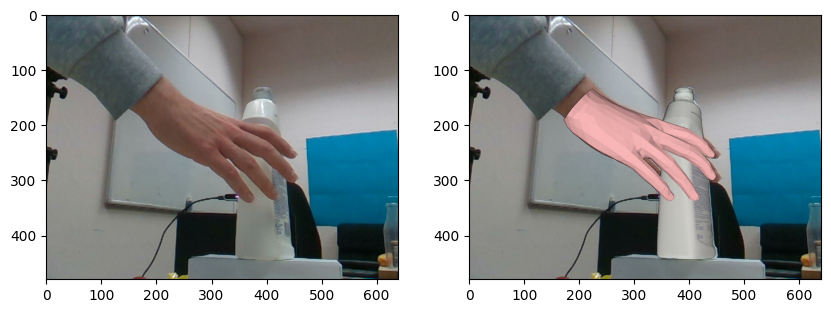

In [37]:
import pyredner # pyredner will be the main Python module we import for redner.
import torch # We also import PyTorch
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from utils.utils import load_ho_meta, apply_transform_to_mesh
from utils.mano import ManoLayer


bg_img = np.array(Image.open('data/HO3D_v3/train/ABF10/rgb/0000.jpg'), dtype=np.float32)/255.0
anno = load_ho_meta('data/HO3D_v3/train/ABF10/meta/0000.pkl')
mano = ManoLayer()
mano_verts = mano(anno)

resolution = bg_img.shape[:2]

mano_object = pyredner.Object(
    vertices=mano_verts[0], 
    indices=mano.faces, 
    uvs=mano.uv,
    material=pyredner.Material(
        diffuse_reflectance=pyredner.Texture(mano.map.to(pyredner.get_device()))
        # diffuse_reflectance=torch.tensor((0.5, 0.5, 0.5), device=pyredner.get_device())))
    )
)
print(mano.faces.dtype)

world2cam = torch.eye(4)
R = torch.diag(torch.tensor([-1.,1.,-1.]))
world2cam[:3,:3] = R
cam2world = world2cam.inverse()
K = torch.tensor(anno['camMat'], dtype=torch.float32)
print(K)

fov = 2* torch.atan(0.5 * resolution[1] / K[0, 0]) * 180 / 3.1415926
print(fov)
camera = pyredner.Camera(
    # intrinsic_mat=K,
    # cam_to_world=cam2world,
    position = torch.tensor([0, 0, 0.], dtype=torch.float32),
    look_at = torch.tensor([0, 0, -1.], dtype=torch.float32),
    up = torch.tensor([0, 1., 0], dtype=torch.float32),
    fov = torch.tensor([fov], dtype=torch.float32),
    resolution=resolution,
)
print(camera.__dict__)
dirlight = pyredner.DirectionalLight(
    direction = torch.tensor([0.0, 0.0, -1.0]), 
    intensity = torch.ones(3)*3.0,
)
# envmap = pyredner.EnvironmentMap(torch.tensor(bg_img))

objects = pyredner.load_obj('data/models/021_bleach_cleanser/textured_simple.obj', return_objects=True)
obj_object = pyredner.Object(
    vertices=apply_transform_to_mesh(objects[0].vertices, anno),
    indices=objects[0].indices, 
    uvs=objects[0].uvs,
    uv_indices=objects[0].uv_indices,
    material=objects[0].material
)

# create scene
scene = pyredner.Scene(
    camera = camera, 
    objects = [
        mano_object, 
        obj_object,
        ]
    )

# Render the scene.
# render = pyredner.render_albedo(scene, alpha=True)
render = pyredner.render_deferred(scene, lights=[dirlight], alpha=True)
    

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(bg_img)
axs[1].imshow(bg_img)
axs[1].imshow(torch.pow(render, 1.0/2.2).cpu())